In [82]:
# import library

import os
from shutil import copy
import xml.etree.ElementTree as ET
import xml
from xml.dom import minidom
import cv2
import numpy as np

In [98]:
datapath = '../../dataset/Annotations'
imagepath = '../../dataset/JPEGImages'
xmllspath = '../../dataset/tasklist/t2_train.txt'
savedir = '../../dataset/PadID/t2_train'
IOSthreshold = 0.3

VOC_CLASS_NAMES = [
    "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat",
    "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]
VOC_CLASS_NAMES_COCOFIED = [
    "airplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat",
    "chair", "cow", "dining table", "dog", "horse", "motorcycle", "person",
    "potted plant", "sheep", "couch", "train", "tv"
]

VOCclass = set(VOC_CLASS_NAMES).union(set(VOC_CLASS_NAMES_COCOFIED))


T2_CLASS_NAMES = [
    "truck", "traffic light", "fire hydrant", "stop sign", "parking meter",
    "bench", "elephant", "bear", "zebra", "giraffe",
    "backpack", "umbrella", "handbag", "tie", "suitcase",
    "microwave", "oven", "toaster", "sink", "refrigerator"
]

T3_CLASS_NAMES = [
    "frisbee", "skis", "snowboard", "sports ball", "kite",
    "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket",
    "banana", "apple", "sandwich", "orange", "broccoli",
    "carrot", "hot dog", "pizza", "donut", "cake"
]

T4_CLASS_NAMES = [
    "bed", "toilet", "laptop", "mouse",
    "remote", "keyboard", "cell phone", "book", "clock",
    "vase", "scissors", "teddy bear", "hair drier", "toothbrush",
    "wine glass", "cup", "fork", "knife", "spoon", "bowl"
]

NONVOCclass = T2_CLASS_NAMES


In [99]:
with open(xmllspath, newline='') as f:
    data = f.read()


xmlls = data.split("\n")

while '' in xmlls:
    xmlls.remove('')

xmlls = [data+'.xml' for data in xmlls]

In [100]:
def calculateIOS(gtbox,cropbox):
    IOSs = []
    for box in gtbox:
        Inter_x_l = max(box[0],cropbox[0])
        Inter_x_r = min(box[1],cropbox[1])
        Inter_y_b = max(box[2],cropbox[2])
        Inter_y_u = min(box[3],cropbox[3])

        width = max(Inter_x_r-Inter_x_l,0)
        length = max(Inter_y_u-Inter_y_b,0)

        InterArea = width*length

        # Area1 = (box[1]-box[0]) * (box[3]-box[2])
        Area2 = (cropbox[1]-cropbox[0]) * (cropbox[3]-cropbox[2])

        # Union = Area1+Area2-InterArea
        if Area2 ==0:
            return 1
        IOS = InterArea/Area2
        IOSs.append(IOS)

    if IOSs == []:
        return 0
    else:
        IOS = max(IOSs)
    return IOS

In [101]:
count = 0
nogood = 0

for idx, singleXml in enumerate(xmlls):
    
    xmlname = os.path.join(datapath,singleXml)
    doc = ET.parse(xmlname)
    root = doc.getroot()
    imagename = root.find('filename').text
    filepath = os.path.join('../../dataset/JPEGImages',imagename)
    objects = root.iter('object')
    src = cv2.imread(filepath)

    padboxs = []

    #Zero Pad VOCclass
    for annotation in objects:
        name = annotation.find('name').text

        if name in VOCclass:
            # get bbox
            bndbox = annotation.find('bndbox')
            
            x_l = int(bndbox.find('ymin').text)
            y_b = int(bndbox.find('xmin').text)
            x_r = int(bndbox.find('ymax').text)
            y_u = int(bndbox.find('xmax').text)
            padboxs.append([x_l,x_r,y_b,y_u])
            
            src[x_l:x_r,y_b:y_u,:] = np.zeros_like(src[x_l:x_r,y_b:y_u,:])
    
    objects = root.iter('object')
    #Crop NONVOCclass
    for annotation in objects:
        name = annotation.find('name').text
        
        if name in NONVOCclass:
            # get bbox
            bndbox = annotation.find('bndbox')
            
            x_l = int(bndbox.find('ymin').text)
            y_b = int(bndbox.find('xmin').text)
            x_r = int(bndbox.find('ymax').text)
            y_u = int(bndbox.find('xmax').text)
            cropbox = [x_l,x_r,y_b,y_u]
            crop = src[x_l:x_r,y_b:y_u,:]

            IOU = calculateIOS(padboxs,cropbox)
            if IOU > IOSthreshold:
                nogood = nogood + 1
                continue

            y = y_u-y_b
            x = x_r-x_l

            if min(x,y) == 0:
                nogood = nogood + 1
                continue

            length = max(x, y)

            top = int(length/2 - x/2)
            bottom = int(length/2 - x/2)
            left = int(length/2 - y/2)
            right = int(length/2 - y/2)

            borderType = cv2.BORDER_CONSTANT

            try:
                assert x_r <= src.shape[0] and y_u <= src.shape[1]
                crop = cv2.copyMakeBorder(crop, top, bottom, left, right, borderType)
                crop = cv2.resize(crop,(256,256))

            # continue for invalid cropping (e.g. cropping outside of source image)
            except Exception:
                continue
            
            # if no dir make one
            savepath = os.path.join(savedir,name)
            if not(os.path.exists(savepath)):
                os.makedirs(savepath)
            
            imgname = name + "_" + imagename
            cropimagepath = os.path.join(savepath,imgname)
            
            # save to dir
            cv2.imwrite(cropimagepath,crop)
            
            # count
            count = count + 1
    
nogood, count

(43522, 63907)

In [79]:
count

6899

In [36]:
nogood, count

(1, 1870)

In [18]:
xmlstr = minidom.parseString(ET.tostring(root)).toprettyxml(indent="   ")
print(xmlstr)

<?xml version="1.0" ?>
<annotation>
   <filename>000000056679.jpg</filename>
   <size>
      <width>426</width>
      <height>640</height>
      <depth>3</depth>
   </size>
   <object>
      <name>person</name>
      <difficult>0</difficult>
      <bndbox>
         <xmin>180</xmin>
         <ymin>272</ymin>
         <xmax>268</xmax>
         <ymax>384</ymax>
      </bndbox>
   </object>
   <object>
      <name>person</name>
      <difficult>0</difficult>
      <bndbox>
         <xmin>398</xmin>
         <ymin>310</ymin>
         <xmax>426</xmax>
         <ymax>411</ymax>
      </bndbox>
   </object>
   <object>
      <name>person</name>
      <difficult>0</difficult>
      <bndbox>
         <xmin>352</xmin>
         <ymin>321</ymin>
         <xmax>366</xmax>
         <ymax>352</ymax>
      </bndbox>
   </object>
   <object>
      <name>person</name>
      <difficult>0</difficult>
      <bndbox>
         <xmin>310</xmin>
         <ymin>334</ymin>
         <xmax>328</xmax>
         <ymax

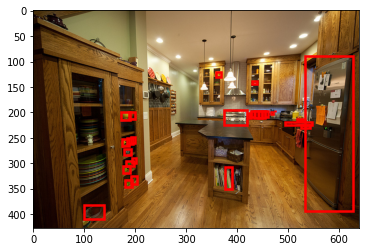

In [64]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches
fig, ax = plt.subplots()

objects = root.iter('object')
for annotation in objects:
    bndbox = annotation.find('bndbox')
            
    x_l = int(bndbox.find('ymin').text)
    y_b = int(bndbox.find('xmin').text)
    x_r = int(bndbox.find('ymax').text)
    y_u = int(bndbox.find('xmax').text)
    box = [x_l,x_r,y_b,y_u]

    patch = patches.Rectangle((box[2], box[0]),
                    box[3]-box[2],
                    box[1]-box[0],
                    edgecolor = 'red',
                    facecolor = None,
                    fill=False,
                    lw = 2.5
                )
    ax.add_patch(patch)
ax.imshow(cv2.cvtColor(src, cv2.COLOR_BGR2RGB))